In [1]:
import os, math, sys
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opti
import shap
from torch.utils.data import Dataset, DataLoader, Subset, random_split

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv, GATConv
from torch_geometric.utils import softmax

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from anomaly_predict import ad_predict
from merlion.evaluate.anomaly import ScoreType, accumulate_tsad_score

from tqdm.auto import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torchvision.ops import focal_loss
import torch.optim as optim
import networkx as nx

## GDNModified 모델 정의

In [2]:
class EdgeAwareGATConv(MessagePassing):
    """
    피드백을 반영한 Edge-Aware GAT 레이어.
    어텐션 계산 시 노드 특징과 엣지 특징을 모두 사용합니다.
    α_ij = attention(h_i, h_j, e_ij)
    """
    def __init__(self, in_channels, out_channels, edge_dim, heads=1, **kwargs):
        super(EdgeAwareGATConv, self).__init__(aggr='add', node_dim=0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.edge_dim = edge_dim

        # 노드 특징(h_i, h_j)을 위한 선형 변환
        self.lin_l = nn.Linear(in_channels, out_channels * heads)
        # 엣지 특징(e_ij)을 위한 선형 변환
        self.lin_edge = nn.Linear(edge_dim, out_channels * heads)
        # 어텐션 스코어 계산을 위한 파라미터
        self.att = nn.Parameter(torch.Tensor(1, heads, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_edge.weight)
        nn.init.xavier_uniform_(self.att)

    def forward(self, x, edge_index, edge_attr):
        # 1. 노드와 엣지 특징을 각 헤드에 맞게 변환
        x_transformed = self.lin_l(x)
        edge_attr_transformed = self.lin_edge(edge_attr)
        
        # 2. 메시지 전파 시작
        return self.propagate(edge_index, x=x_transformed, edge_attr=edge_attr_transformed)

    def message(self, x_j, x_i, edge_attr, index, ptr, size_i):
        # x_i: 타겟 노드 특징, x_j: 소스 노드 특징
        # edge_attr: 엣지 특징
        x_i = x_i.view(-1, self.heads, self.out_channels)
        x_j = x_j.view(-1, self.heads, self.out_channels)
        edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
        
        # 3. 어텐션 스코어 계산
        # 소스 노드, 타겟 노드, 엣지 특징을 모두 더한 후 LeakyReLU 적용
        alpha = F.leaky_relu(x_i + x_j + edge_attr)
        
        # 4. 최종 어텐션 스코어 계산
        alpha = (alpha * self.att).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, size_i)
        
        # 5. 어텐션 가중치를 소스 노드 특징(x_j)에 곱하여 메시지 생성
        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        # 각 헤드의 출력을 연결(concatenate)
        return aggr_out.view(-1, self.out_channels * self.heads)

In [3]:
class CustomGATModel_EdgeAware(nn.Module):
    """
    Edge-Aware GAT와 TCN을 결합한 최종 분류 모델.
    """
    def __init__(self, num_features, window_size, tcn_out_channels, gat_out_dim, edge_feature_dim, heads=4, dropout=0.5):
        super(CustomGATModel_EdgeAware, self).__init__()

        # --- 1. 시간적 특징 추출을 위한 TCN 레이어 ---
        self.tcn = nn.Conv1d(
            in_channels=num_features, 
            out_channels=tcn_out_channels, 
            kernel_size=3, 
            padding=1
        )
        
        # --- 2. 공간적 특징 추출을 위한 EdgeAwareGAT 레이어 ---
        # GATConv -> EdgeAwareGATConv 로 변경, edge_dim 인자 추가
        self.gat1 = EdgeAwareGATConv(
            in_channels=window_size, 
            out_channels=gat_out_dim, 
            edge_dim=edge_feature_dim, # 엣지 특징의 차원 (2)
            heads=heads
        )
        self.elu = nn.ELU()

        # --- 3. 최종 분류를 위한 MLP (Classification Head) ---
        gat_output_flat_dim = num_features * gat_out_dim * heads
        
        self.classification_head = nn.Sequential(
            nn.Linear(gat_output_flat_dim, gat_output_flat_dim // 4),
            nn.BatchNorm1d(gat_output_flat_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(gat_output_flat_dim // 4, 2),
        )

    def forward(self, x, edge_index, edge_attr):
        # x: (B, W, N), edge_index: (2, E), edge_attr: (B, E, D_edge)
        
        # --- 1. 시간적 특징 추출 ---
        x_t = x.permute(0, 2, 1)
        x_tcn = self.tcn(x_t)
        x_tcn = x_tcn.permute(0, 2, 1)
        
        # --- 2. 공간적 특징 추출 ---
        x_g = x_tcn.permute(0, 2, 1)
        
        batch_outs = []
        for i in range(x_g.shape[0]):
            x_sample = x_g[i] # (N, W)
            attr_sample = edge_attr[i] # (E, D_edge)
            
            # gat1에 edge_attr 전달
            gat_out = self.gat1(x_sample, edge_index, edge_attr=attr_sample)
            gat_out = self.elu(gat_out)
            batch_outs.append(gat_out)
        
        x_gat = torch.stack(batch_outs, dim=0) # (B, N, gat_out_dim * heads)
        
        # --- 3. 최종 분류 ---
        x_flat = x_gat.reshape(x_gat.size(0), -1)
        logits = self.classification_head(x_flat)
        
        return logits

## 데이터로딩

In [4]:
def dataframe_from_csv(path):
    return pd.read_csv(path, sep=",") \
             .rename(columns=lambda x: x.strip())

def dataframe_from_csvs(paths):
    return pd.concat([dataframe_from_csv(p) for p in paths],
                     ignore_index=True)

# 파일 경로 리스트 (사용할 두 개 파일만)
paths = [
    "./data/asherah_s.csv"
]
data = "com1"
train_orig = pd.read_csv(f'../TranAD/data/test/rx/htr/htr2.csv', index_col=0)
test_orig = pd.read_csv(f'../TranAD/data/test/rx/com/pzr_{data}.csv', index_col=0)

In [5]:
def normalize(df, tag_min, tag_max):
    ndf = df.copy()
    for c in df.columns:
        if tag_min[c] == tag_max[c]:
            ndf[c] = df[c] - tag_min[c]
        else:
            ndf[c] = (df[c] - tag_min[c]) / (tag_max[c] - tag_min[c])
    return ndf


In [6]:
not_valid_field = ["time"]
# not_valid_field = ["attack"]
# valid_columns = test_orig.columns.drop(not_valid_field)
valid_columns = test_orig.columns

# 각 컬럼별 최소/최대값 계산 (훈련 데이터 기준)
tag_min_train = train_orig[valid_columns].min()
tag_max_train = train_orig[valid_columns].max()

tag_min_test = test_orig[valid_columns].min()
tag_max_test = test_orig[valid_columns].max()

tag_min = np.minimum(tag_min_train, tag_min_test)
tag_max = np.maximum(tag_max_train, tag_max_test)

# 정규화된 훈련 데이터셋 생성
train = normalize(train_orig[valid_columns][:12000], tag_min, tag_max)
test = normalize(test_orig[valid_columns][:12000], tag_min, tag_max)

print(train.shape, test.shape)

(12000, 127) (12000, 127)


In [7]:
labels_train = np.zeros(train.shape[0])
labels_test = np.zeros(test.shape[0])
labels_train[6000:] = 1
labels_test[6000:] = 1

In [8]:
train_labels = pd.DataFrame(labels_train, columns=["attack"])
test_labels = pd.DataFrame(labels_test, columns=["attack"])
train_labels.index = train.index
test_labels.index = test.index

train = pd.concat([train, train_labels], axis=1)
test = pd.concat([test, test_labels], axis=1)

In [9]:
# train: pd.DataFrame
def pick(prefixes):
    P = tuple(p.lower() for p in prefixes)
    return [c for c in train.columns if c.lower().startswith(P)]

# Reactor (원자로/출력/CEA·발전기)
reactor_vars = pick((
    "bufss",                 # THERMAL POWER
    "enfms.nfsc_lin",        # REACTOR POWER
    "txmpji003.output",      # GENERATOR POWER
    "rrsterr.output",        # CEA MOTION DEMAND
))

# RCS (평균/기준/Hot/Cold/압력/SM 온도)
rcs_vars = pick((
    "rrstavg.output", "rrstref.output",
    "txrcte132", "txrcte133", "txrcte142", "txrcte143",
    "txrcpt102", "iccm.tmarrcs",
))

# RCP
rcp_vars = pick((
    "mtrcpp01a.rotorspeed","mtrcpp01b.rotorspeed",
    "mtrcpp02a.rotorspeed","mtrcpp02b.rotorspeed",
    "mtrcpp01a.status","mtrcpp01b.status",
    "mtrcpp02a.status","mtrcpp02b.status",
))

# PZR (수위/스프레이/히터/알람/제어)
pzr_vars = pick((
    "txrclt110",                 # level
    "rcpi102.output","txrcpt102",# pressure pv
    "aovrc100e.avpvpos","aovrc100f.avpvpos",  # spray pos (1~10V)
    "hilout_cn_9_431_m_pz01_",   # prop/backup heater on/off
    "txngii100", "txrchtrb",     # heater currents
    "swrcps100n04.limit_low", "lpp_pretripa.setpoint", "_rlngtb735.output_r",  # alarms
    "rcly1113.output", "rcpy102.output", "crppcs_pv.output",
    "ctrcpik100.anvsp_real", "ctrclik110.", "ctrchik100.rmtspreal",
    "plcs-l110-",                # level loop signals
))

# SG (압력/수위/증기·급수유량)
sg_vars = pick((
    "txmspt1013a.output","txmspt1023a.output",
    "txfwlt1113a.output","txfwlt1123a.output",
    "txfwlt1114a.output","txfwlt1124a.output",
    "crsbcs_ssfs1.output","crsbcs_ssfs2.output",
    "txfwft1112x.output","txfwft1122x.output",
    "txfwft1113x.output","txfwft1113y.output",
    "txfwft1123x.output","txfwft1123y.output",
))

# Turbine
tb_vars = pick((
    "tbnspeed.output", "txtapt135.output", "txtapt143.output",
))

# Condenser
cd_vars = pick((
    "bkcdpp01.state","bkcdpp02.state","bkcdpp03.state",
    "bkcapp01.state","bkcapp02.state","bkcapp03.state","bkcapp04.state",
    "cdpi485.output","txcdlt021.output","txcdlt005.output","txcdte037.output",
))

# FW / FWPT / 급수제어
fw_vars = pick((
    "txfst3101x.output","txfst3102x.output","txfst3103x.output",  # FWPT speed (표기 txFTST와 혼용될 수 있어 루트만 사용)
    "fwzi1113.output","fwzi1123.output","fwzi1112.output","fwzi1122.output",
    "crfwcs1_fc1111_sp.output","ctrfwfc1111.anvcmd100","crfwcs1_fc1111_pv.output",
    "crfwcs2_fc1121_sp.output","ctrfwfc1121.anvcmd100","crfwcs2_fc1121_pv.output",
    "ctfwhic1112.anvsp_real","ctfwhic1112.anvcmd100","ctfwhic1112.ixvinputreal",
    "ctfwhic1113.anvsp_real","ctfwhic1113.anvcmd100","ctfwhic1113.ixvinputreal",
    "ctfwhic1122.anvsp_real","ctfwhic1122.anvcmd100","ctfwhic1122.ixvinputreal",
    "ctfwhic1123.anvsp_real","ctfwhic1123.anvcmd100","ctfwhic1123.ixvinputreal",
))

# CNMT (격납/살수)
cnmt_vars = pick((
    "txcmpt351", "txcmpt352", "txcmlt027", "txcmlt028",
    "txcspt071.output","txcspt081.output","txcsft338c.output","txcsft348d.output",
))

# SI (안전주입 압력/유량)
si_vars = pick((
    "txsipt308.output","txsipt306.output","txsipt309.output","txsipt307.output",
    "txsift341a.output","txsift311d.output","txsift331c.output","txsift321b.output",
))

# Misc (CVCS 유량, SIAS)
misc_vars = pick((
    "txcvft212b.output","txcvft202.output", "alef_sias.output",
))

# 최종 배열
column_groups = [
    reactor_vars,
    rcs_vars,
    rcp_vars,
    pzr_vars,
    sg_vars,
    tb_vars,
    cd_vars,
    fw_vars,
    cnmt_vars,
    si_vars,
    misc_vars,
]



In [10]:
def create_fixed_edge_index(all_columns, column_groups):
    """
    사전 정의된 컬럼 그룹을 기반으로 고정된 edge_index를 생성합니다.
    같은 그룹에 속한 노드들끼리만 엣지로 연결됩니다.

    Args:
        all_columns (list): 모든 특징(feature) 컬럼 이름의 리스트.
        column_groups (list of lists): 그룹화된 컬럼 이름 리스트.

    Returns:
        torch.Tensor: PyTorch Geometric 형식의 edge_index [2, num_edges].
    """
    # 컬럼 이름을 정수 인덱스로 매핑하는 딕셔너리 생성
    col_to_idx = {col: i for i, col in enumerate(all_columns)}
    
    edge_list = []
    # 각 그룹에 대해 반복
    for group in column_groups:
        # 그룹 내에 존재하는 컬럼만 필터링
        valid_group_cols = [col for col in group if col in col_to_idx]
        
        # 그룹 내 모든 컬럼 쌍(엣지)을 생성
        for col1, col2 in combinations(valid_group_cols, 2):
            idx1, idx2 = col_to_idx[col1], col_to_idx[col2]
            # 무방향 그래프이므로 양방향으로 엣지 추가
            edge_list.append([idx1, idx2])
            edge_list.append([idx2, idx1])
            
    # 중복 엣지 제거 및 정렬 (선택 사항이지만 좋은 습관)
    if not edge_list:
        return torch.empty((2, 0), dtype=torch.long)
        
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # self-loop 추가 (GAT/GCN 성능에 도움이 됨)
    # from torch_geometric.utils import add_self_loops
    # edge_index, _ = add_self_loops(edge_index, num_nodes=len(all_columns))
    
    print(f"고정된 엣지 생성 완료. 총 {edge_index.shape[1]}개의 엣지가 생성되었습니다.")
    return edge_index

fixed_edge_index = create_fixed_edge_index(valid_columns, column_groups)

고정된 엣지 생성 완료. 총 1426개의 엣지가 생성되었습니다.


In [11]:
class WeightDataset(Dataset):
    def __init__(self, df, edge_index, base_pearson_weights, config):
        """
        [수정] label 인자를 제거하고, df에 'attack' 컬럼이 포함되어 있다고 가정합니다.
        """
        self.labels = df['attack'].values
        self.features = df.drop('attack', axis=1).values
        
        self.edge_index = edge_index
        self.base_pearson_weights = base_pearson_weights
        self.win_size = config.get('win_size', 96)

    def __len__(self):
        return len(self.features) - self.win_size + 1

    def __getitem__(self, index):
        x_window = self.features[index : index + self.win_size]
        
        # [수정] 윈도우의 마지막 시점의 레이블을 가져옵니다.
        label = self.labels[index + self.win_size - 1]

        # --- 엣지 특징 계산 (기존과 동일) ---
        last_time_step = x_window[-1, :]
        diff = last_time_step[self.edge_index[0]] - last_time_step[self.edge_index[1]]
        dynamic_diff_weights = torch.from_numpy(np.abs(diff)).float()

        static_feat = self.base_pearson_weights.unsqueeze(1)
        dynamic_feat = dynamic_diff_weights.unsqueeze(1)
        
        final_edge_attr = torch.cat([static_feat, dynamic_feat], dim=1)

        return (
            torch.from_numpy(x_window).float(),
            torch.tensor(label).long(), # 레이블 타입을 long으로 변경
            self.edge_index,
            final_edge_attr
        )

In [12]:
base_adj = train.corr(method='pearson').abs().fillna(0).values

base_pearson_weights = torch.from_numpy(base_adj[fixed_edge_index[0], fixed_edge_index[1]]).float()

In [13]:
config = {'win_size': 96}
train_dataset = WeightDataset(
    df=train, # attack 컬럼이 포함된 df 전달
    edge_index=fixed_edge_index,
    base_pearson_weights=base_pearson_weights,
    config=config
)

test_dataset = WeightDataset(
    df=test, # attack 컬럼이 포함된 df 전달
    edge_index=fixed_edge_index,
    base_pearson_weights=base_pearson_weights,
    config=config
)

In [14]:
val_ratio = 0.2  # 20%를 검증용으로 사용
val_len = int(len(train_dataset) * val_ratio)
train_len = len(train_dataset) - val_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])
print(f"학습 데이터셋 분리 완료. Train: {len(train_dataset)}개, Validation: {len(val_dataset)}개")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) # 이제 val_dataset을 사용
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"\n학습 데이터셋 샘플 수: {len(train_dataset)}")
print(f"\n검증 데이터셋 샘플 수: {len(val_dataset)}")
print(f"테스트 데이터셋 샘플 수: {len(test_dataset)}")

학습 데이터셋 분리 완료. Train: 9524개, Validation: 2381개

학습 데이터셋 샘플 수: 9524

검증 데이터셋 샘플 수: 2381
테스트 데이터셋 샘플 수: 11905


## 그래프 데이터셋 생성 (SlidingGraphDataset)

### split 8:1:1

In [15]:
NUM_FEATURES = 127
WINDOW_SIZE = config['win_size']
EDGE_FEATURE_DIM = 2
print(WINDOW_SIZE)

96


In [16]:
model = CustomGATModel_EdgeAware(
    num_features=NUM_FEATURES,
    window_size=WINDOW_SIZE,
    tcn_out_channels=NUM_FEATURES,
    gat_out_dim=16,
    edge_feature_dim=EDGE_FEATURE_DIM, # 인자 추가
    heads=4
)

In [17]:
def custom_loss_fn(pred, label):
    # pred: [B, C], label: [B]
    assert pred.ndim == 2, f"pred shape={tuple(pred.shape)}"
    if label.ndim > 1:
        label = label.view(-1)
    assert pred.size(0) == label.size(0), f"batch mismatch: {tuple(pred.shape)} vs {tuple(label.shape)}"
    return nn.CrossEntropyLoss()(pred, label.long())


In [18]:
ad_config = {
    'threshold_determine': 'floating',  # 'floating' 또는 'fix' 등
    'detect_nu': 0.002,
    'lr': 3e-4
}

In [19]:

class EarlyStopping:
    """
    단순 값 비교를 넘어, 최적 모델의 state_dict와 예측 결과(score)까지 저장하여
    과적합을 방지하고 최상의 모델을 보존합니다.
    """
    def __init__(self, path='best_model.pt', patience=5, delta=0):
        self.path = path
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_indicator = -np.inf  # 조기 종료 판단의 기준이 되는 값 (클수록 좋음)
        self.best_model_state = None
        self.best_val_scores = None
        self.best_test_scores = None
        self.early_stop = False

    def __call__(self, indicator, model, val_scores, test_scores):
        is_best = indicator > self.best_indicator + self.delta

        if is_best:
            self.best_indicator = indicator
            self.best_model_state = model.state_dict().copy()
            self.best_val_scores = val_scores
            self.best_test_scores = test_scores
            self.counter = 0
            torch.save(self.best_model_state, self.path)
            print(f"✅ EarlyStopping: New best model found with indicator: {indicator:.4f}. Saved to {self.path}")
        else:
            self.counter += 1
            print(f"⚠️ EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# --- 2. 재구성된 GAT_Trainer 클래스 ---
class GAT_Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader, config, device='cuda', path='best_model.pt'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        # 참고: lr, weight_decay 등은 config에서 가져오는 것이 더 유연합니다.
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.get('lr', 3e-4), weight_decay=config.get('weight_decay', 1e-5))
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=3)
        self.path = path
        self.config = config
        print(f"Trainer initialized on device: {self.device}")

    def _train_epoch(self):
        """한 에포크 동안 모델을 학습시킵니다."""
        self.model.train()
        total_loss = 0.0
        for x_batch, label_batch, edge_index_batch, attr_batch in self.train_loader:
            x_batch, labels = x_batch.to(self.device), label_batch.to(self.device).long()
            edge_index, attr_batch = edge_index_batch[0].to(self.device), attr_batch.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(x_batch, edge_index, attr_batch)
            loss = custom_loss_fn(logits, labels) # custom_loss_fn은 별도 정의 필요
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * labels.size(0)
        return total_loss / len(self.train_loader.dataset)

    @torch.no_grad()
    def _evaluate_epoch(self, loader):
        self.model.eval()
        total_loss = 0.0
        all_labels, all_scores = [], []
        for x_batch, label_batch, edge_index_batch, attr_batch in loader:
            x_batch, labels = x_batch.to(self.device), label_batch.to(self.device).long()
            edge_index, attr_batch = edge_index_batch[0].to(self.device), attr_batch.to(self.device)
    
            logits = self.model(x_batch, edge_index, attr_batch)
            loss = custom_loss_fn(logits, labels)
            total_loss += loss.item() * labels.size(0)
    
            scores = torch.softmax(logits, dim=1)[:, 1]
            all_labels.append(labels.cpu().numpy()) # .numpy()로 변환
            all_scores.append(scores.cpu().numpy()) # .numpy()로 변환
    
        avg_loss = total_loss / len(loader.dataset)
        
        # [수정] numpy 배열들을 올바르게 합치고 flatten() 적용
        labels = np.concatenate(all_labels).flatten()
        scores = np.concatenate(all_scores).flatten()

        
        # [수정] 길이 조정 코드 제거 (이제 필요 없음)
        
        return avg_loss, labels, scores

    def train(self, num_epochs=20, patience=5):
        """
        모델 학습을 시작하고, 조기 종료 후 최적 모델로 최종 성능을 평가 및 출력합니다.
        """
        early_stopping = EarlyStopping(path=self.path, patience=patience)
        train_hist, val_hist = [], []

        for epoch in range(1, num_epochs + 1):
            # --- 1. 학습 및 평가 ---
            train_loss = self._train_epoch()
            val_loss, val_labels, val_scores = self._evaluate_epoch(self.val_loader)
            _, _, test_scores = self._evaluate_epoch(self.test_loader) # 테스트 점수도 함께 저장

            self.scheduler.step(val_loss)
            train_hist.append(train_loss)
            val_hist.append(val_loss)

            # --- 2. 성능 지표 계산 및 출력 ---
            val_affiliation, val_rpa_score, _, _, _ = ad_predict(
                target=val_labels, scores=val_scores,
                mode=self.config['threshold_determine'], nu=self.config['detect_nu']
            )
            val_f1 = val_rpa_score.f1(ScoreType.RevisedPointAdjusted)
            # ap = average_precision_score(val_labels, val_scores)

        
            
            print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1 (RPA): {val_f1:.4f}")

            # --- 3. 조기 종료 확인 ---
            early_stopping(val_f1, self.model, val_scores, test_scores)
            if early_stopping.early_stop:
                print(f"⏹ Early stopping at epoch {epoch}")
                break

        # --- 4. 최종 결과 리포트 ---
        print("\n################## Training is Done! #########################")
        print(f"Loading best model from epoch with F1: {early_stopping.best_indicator:.4f}")
        
        best_val_scores = early_stopping.best_val_scores
        best_test_scores = early_stopping.best_test_scores
        
        _, val_labels, _ = self._evaluate_epoch(self.val_loader)
        _, test_labels, _ = self._evaluate_epoch(self.test_loader)

        final_results = self._report_final_metrics(val_labels, best_val_scores, test_labels, best_test_scores)
        
    
        return train_hist, val_hist, final_results, test_labels, best_test_scores


    def test(self):
        """저장된 최적 모델을 불러와 최종 성능을 평가합니다."""
        print(f"\nLoading best model from {self.path} for final testing.")
        try:
            self.model.load_state_dict(torch.load(self.path, map_location=self.device))
        except FileNotFoundError:
            print(f"Error: Model file not found at {self.path}. Please train the model first.")
            return None

        # 데이터 로더에서 라벨과 점수 추출
        _, val_labels, val_scores = self._evaluate_epoch(self.val_loader)
        _, test_labels, test_scores = self._evaluate_epoch(self.test_loader)
        
        # 최종 성능 평가 및 출력
        final_results = self._report_final_metrics(val_labels, val_scores, test_labels, test_scores)
        return final_results, test_labels, test_scores
        
    def _report_final_metrics(self, val_labels, val_scores, test_labels, test_scores):
        """최종 성능 지표를 계산하고 출력하는 헬퍼 함수"""
        
        # --- 검증 데이터셋 결과 ---
        print("\n--- Validation Set Results (Best Model) ---")
        val_affiliation, val_rpa_score, val_pa_score, val_pw_score, _ = ad_predict(
            val_labels, val_scores, self.config['threshold_determine'], self.config['detect_nu']
        )
        self._print_metrics("Validation", val_affiliation, val_rpa_score, val_pa_score, val_pw_score)

        # --- 테스트 데이터셋 결과 ---
        print("\n--- Test Set Results (Best Model) ---")
        test_affiliation, test_rpa_score, test_pa_score, test_pw_score, _ = ad_predict(
            test_labels, test_scores, self.config['threshold_determine'], self.config['detect_nu']
        )
        self._print_metrics("Test", test_affiliation, test_rpa_score, test_pa_score, test_pw_score)
        
        # 나중에 사용하기 위해 결과값들을 딕셔너리로 묶어 반환
        final_results = {
            'validation': {'affiliation': val_affiliation, 'rpa': val_rpa_score, 'pa': val_pa_score, 'pw': val_pw_score},
            'test': {'affiliation': test_affiliation, 'rpa': test_rpa_score, 'pa': test_pa_score, 'pw': test_pw_score}
        }
        return final_results


    def _print_metrics(self, prefix, affiliation, rpa_score, pa_score, pw_score):
        """성능 지표를 형식에 맞게 출력하는 헬퍼 함수"""
        # Affiliation
        aff_p, aff_r = affiliation.get('precision', 0), affiliation.get('recall', 0)
        aff_f1 = 2 * (aff_p * aff_r) / (aff_p + aff_r) if (aff_p + aff_r) > 0 else 0
        print(f"[{prefix} Affiliation] Precision: {aff_p:2.4f} | Recall: {aff_r:2.4f} | F1: {aff_f1:2.4f}")
        
        # RPA
        rpa_f1 = rpa_score.f1(ScoreType.RevisedPointAdjusted)
        rpa_p = rpa_score.precision(ScoreType.RevisedPointAdjusted)
        rpa_r = rpa_score.recall(ScoreType.RevisedPointAdjusted)
        print(f"[{prefix} RPA]         F1: {rpa_f1:2.4f} | Precision: {rpa_p:2.4f} | Recall: {rpa_r:2.4f}")

        # PA
        pa_f1 = pa_score.f1(ScoreType.PointAdjusted)
        pa_p = pa_score.precision(ScoreType.PointAdjusted)
        pa_r = pa_score.recall(ScoreType.PointAdjusted)
        print(f"[{prefix} PA]          F1: {pa_f1:2.4f} | Precision: {pa_p:2.4f} | Recall: {pa_r:2.4f}")

        # PW
        pw_f1 = pw_score.f1(ScoreType.Pointwise)
        pw_p = pw_score.precision(ScoreType.Pointwise)
        pw_r = pw_score.recall(ScoreType.Pointwise)
        print(f"[{prefix} Pointwise]   F1: {pw_f1:2.4f} | Precision: {pw_p:2.4f} | Recall: {pw_r:2.4f}")

In [20]:
trainer = GAT_Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    config=ad_config,
    path=f'{data}_model.pt',
)


Trainer initialized on device: cuda


In [21]:
train_hist, val_hist, final_results, test_labels, best_test_scores = trainer.train(num_epochs=100, patience=10)

Best affiliation threshold: -1.01
Best RPA threshold: -1.01
Best PA threshold: -1.0100000000000424
Execution time: 67.11820 seconds
Epoch 01 | Train Loss: 0.0116 | Val Loss: 0.0004 | Val F1 (RPA): 1.0000
✅ EarlyStopping: New best model found with indicator: 1.0000. Saved to com1_model.pt
Best affiliation threshold: -3.00
Best RPA threshold: -3.00
Best PA threshold: -3.0
Execution time: 12.27508 seconds
Epoch 02 | Train Loss: 0.0015 | Val Loss: 14.8627 | Val F1 (RPA): 0.5099
⚠️ EarlyStopping counter: 1 out of 10
Best affiliation threshold: -1.01
Best RPA threshold: -1.01
Best PA threshold: -1.0100000000000424
Execution time: 67.75915 seconds
Epoch 03 | Train Loss: 0.0009 | Val Loss: 0.0002 | Val F1 (RPA): 1.0000
⚠️ EarlyStopping counter: 2 out of 10
Best affiliation threshold: -1.01
Best RPA threshold: -1.01
Best PA threshold: -1.0100000000000424
Execution time: 67.81745 seconds
Epoch 04 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val F1 (RPA): 1.0000
⚠️ EarlyStopping counter: 3 out of 10

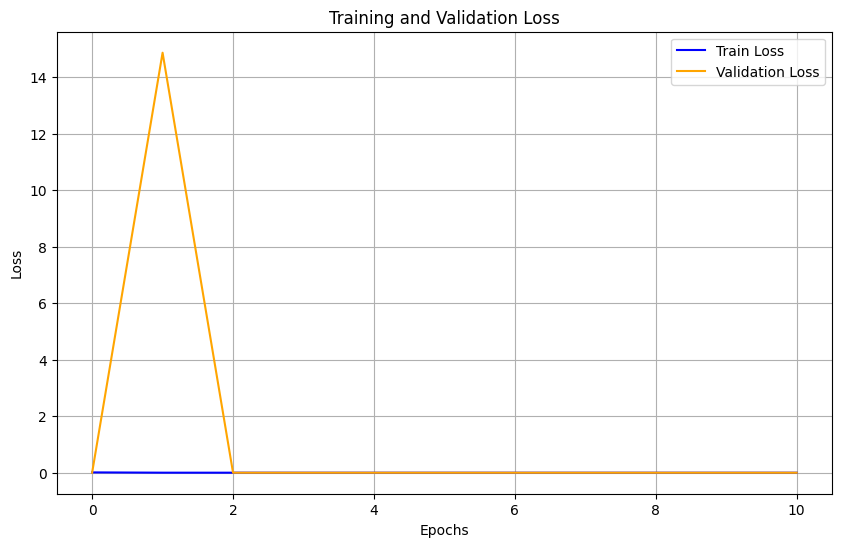

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Train Loss', color='blue')
plt.plot(val_hist, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
final_results, test_labels, test_scores = trainer.test()


Loading best model from com1_model.pt for final testing.

--- Validation Set Results (Best Model) ---
Best affiliation threshold: -1.01
Best RPA threshold: -1.01
Best PA threshold: -1.0100000000000424
Execution time: 67.47770 seconds
[Validation Affiliation] Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
[Validation RPA]         F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
[Validation PA]          F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
[Validation Pointwise]   F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000

--- Test Set Results (Best Model) ---
Best affiliation threshold: -0.65
Best RPA threshold: -0.65
Best PA threshold: -0.6500000000000501
Execution time: 33.58690 seconds
[Test Affiliation] Precision: 1.0000 | Recall: 0.9169 | F1: 0.9567
[Test RPA]         F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
[Test PA]          F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
[Test Pointwise]   F1: 0.7453 | Precision: 1.0000 | Recall: 0.5940


In [24]:
SAVE_DIR = "./analysis/rx"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- helpers ----
def _maybe_to_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)

def _to_probs(arr, positive_index=1):
    """
    arr: (N,) or (N,2)
      - (N,) 가 0..1 범위면 그대로 확률로 사용
      - (N,) 가 로짓이면 sigmoid
      - (N,2) 이면 softmax 또는 이미 확률이면 그대로, positive_index 열 사용
    """
    a = _maybe_to_numpy(arr)
    if a.ndim == 2 and a.shape[1] == 2:
        # 확률인지 확인
        if np.all((a >= 0) & (a <= 1)) and np.allclose(a.sum(axis=1), 1, atol=1e-3):
            return a[:, positive_index]
        # softmax
        e = np.exp(a - a.max(axis=1, keepdims=True))
        sm = e / e.sum(axis=1, keepdims=True)
        return sm[:, positive_index]
    if a.ndim == 1:
        if a.min() >= 0 and a.max() <= 1:
            return a
        # sigmoid (logits)
        return 1.0 / (1.0 + np.exp(-a))
    raise ValueError(f"Unsupported shape for probs: {a.shape}")

def _resolve_from_globals(names):
    g = globals()
    for n in names:
        if n in g:
            try:
                return _maybe_to_numpy(g[n])
            except Exception:
                pass
    return None

# ---- 1) 정답 라벨 y 찾기 ----
y_candidates = [
    "test_labels", "y_true", "y_test", "labels", "gt", "ground_truth"
]
y_arr = _resolve_from_globals(y_candidates)
if y_arr is None:
    raise NameError(f"정답 라벨을 찾지 못했습니다. 가능한 이름: {y_candidates}")

y_arr = _maybe_to_numpy(y_arr).astype(int).ravel()

# ---- 2) 예측 확률/로짓 p 소스 찾기 ----
p_sources = [
    # 확률
    "our_probs", "test_probs", "probs", "y_score", "scores", "pred_proba",
    # 로짓
    "our_logits", "test_logits", "logits", "outputs", "pred_logit", "score_logits",
    # (N,2) 형태
    "test_scores", "y_proba", "proba", "prob_2d"
]
p_raw = _resolve_from_globals(p_sources)
if p_raw is None:
    raise NameError(f"예측 점수/확률을 찾지 못했습니다. 가능한 이름: {p_sources}")

p_arr = _to_probs(p_raw, positive_index=1).astype(float).ravel()
p_arr = np.clip(p_arr, 1e-6, 1-1e-6)

# ---- 3) 길이 검증 ----
if len(y_arr) != len(p_arr):
    raise ValueError(f"길이 불일치: len(y)={len(y_arr)}, len(p)={len(p_arr)}")

# ---- 4) 저장 (.npy + .csv) ----
y_path_npy = os.path.join(SAVE_DIR, "y_gtad.npy")
p_path_npy = os.path.join(SAVE_DIR, "p_gtad.npy")
np.save(y_path_npy, y_arr)
np.save(p_path_npy, p_arr)

y_path_csv = os.path.join(SAVE_DIR, "y_gtad.csv")
p_path_csv = os.path.join(SAVE_DIR, "p_gtad.csv")
pd.DataFrame({"y": y_arr}).to_csv(y_path_csv, index=False)
pd.DataFrame({"p": p_arr}).to_csv(p_path_csv, index=False)

print("[OK] saved:")
print("  ", y_path_npy, "/", y_path_csv)
print("  ", p_path_npy, "/", p_path_csv)
print("shapes:", y_arr.shape, p_arr.shape)

[OK] saved:
   ./analysis/rx/y_gtad.npy / ./analysis/rx/y_gtad.csv
   ./analysis/rx/p_gtad.npy / ./analysis/rx/p_gtad.csv
shapes: (11905,) (11905,)


In [25]:
test_labels.shape

(11905,)

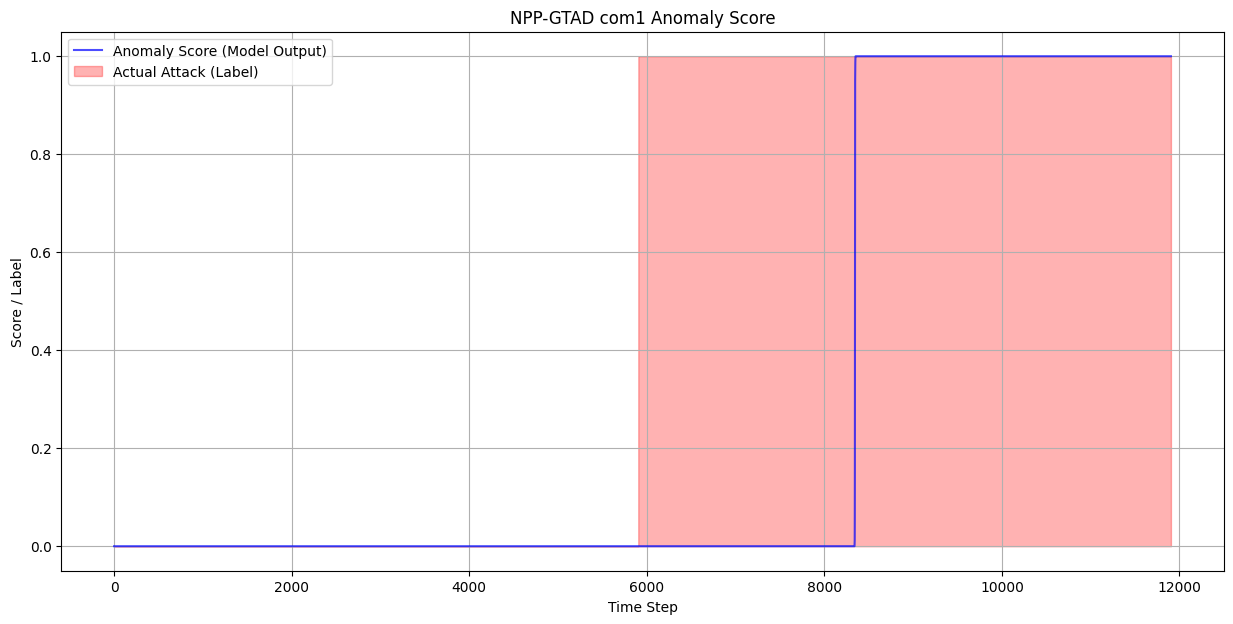

In [31]:
# 그래프를 그립니다.
plt.figure(figsize=(15, 7))
plt.plot(test_scores, label='Anomaly Score (Model Output)', color='blue', alpha=0.7)
plt.fill_between(range(len(test_labels)), test_labels, color='red', alpha=0.3, label='Actual Attack (Label)')
plt.title(f'NPP-GTAD {data} Anomaly Score')
plt.xlabel('Time Step')
plt.ylabel('Score / Label')
plt.legend()
plt.grid(True)
plt.show()

✅ 분석 대상 이상 샘플 인덱스: 8358

Calculating Gradient-based Saliency...


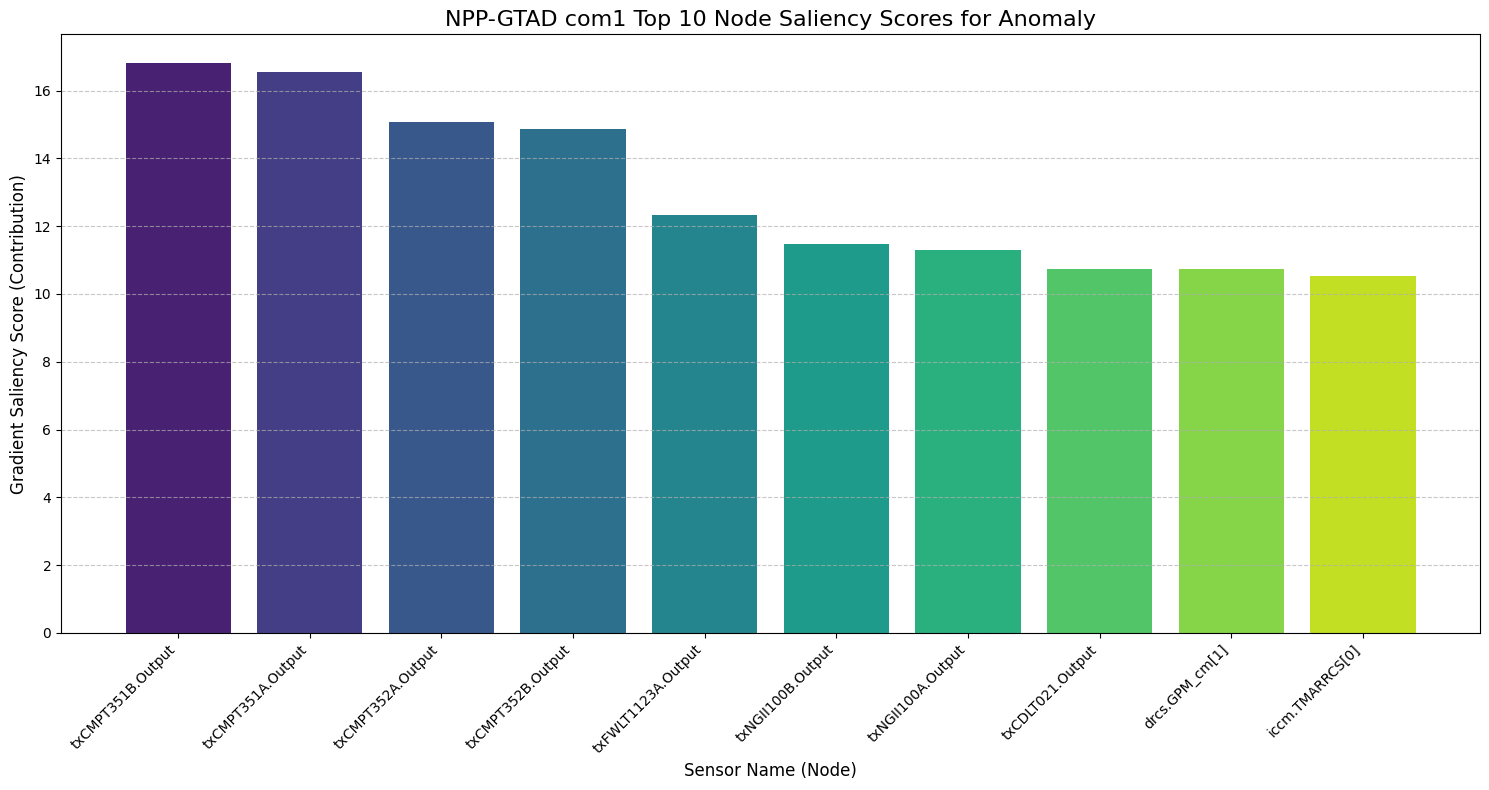

In [27]:
# ====================================================================
# 1. 분석 대상 이상(Anomaly) 샘플 선택 (기존과 동일)
# ====================================================================

# trainer.test() 또는 train()이 반환한, 길이가 조정된 레이블과 점수를 사용합니다.
# final_results, adjusted_labels, scores_from_test = trainer.test()

# 점수가 0.5를 넘는 '공격' 예측 중, 실제 '공격'인 경우를 찾습니다.
correct_anomalies = np.where((test_labels == 1) & (test_scores > 0.000025))[0]

if len(correct_anomalies) > 0:
    # 가장 이상치 점수가 높은, 확실한 샘플을 분석 대상으로 선택합니다.
    target_idx = correct_anomalies[np.argmax(test_scores[correct_anomalies])]
    print(f"✅ 분석 대상 이상 샘플 인덱스: {target_idx}")
else:
    print("⚠️ 올바르게 탐지된 이상 샘플을 찾지 못했습니다. 첫 번째 이상 샘플을 분석합니다.")
    target_idx = np.where(adjusted_labels == 1)[0][0]

# test_dataset에서 해당 인덱스의 원본 데이터를 가져옵니다.
x_window, label, edge_index, edge_attr_sample = test_dataset[target_idx]

# 모델에 입력하기 위해 배치 차원(1)을 추가하고 GPU로 보냅니다.
x_window = x_window.unsqueeze(0).to(trainer.device)
edge_attr_sample = edge_attr_sample.unsqueeze(0).to(trainer.device)
edge_index = edge_index.to(trainer.device)

# ====================================================================
# 2. 그래디언트 기반 Saliency 계산
# ====================================================================
print("\nCalculating Gradient-based Saliency...")

# [핵심] 입력 데이터(x_window)에 대한 그래디언트를 계산하도록 설정합니다.
x_window.requires_grad = True

# 모델을 평가 모드로 설정
model.eval()

# 순전파(forward pass)를 수행하여 로짓(logits)을 얻습니다.
# edge_attr도 GPU에 있어야 합니다.
logits = model(x_window, edge_index, edge_attr_sample)

# '이상' 클래스(인덱스 1)에 대한 로짓 값을 선택합니다.
# Softmax를 통과하기 전의 값을 사용해야 신호가 더 명확합니다.
s_anomaly = logits[0, 1]

# 입력에 대한 로짓의 그래디언트를 계산합니다 (역전파).
s_anomaly.backward()

# 계산된 그래디언트를 가져옵니다. 형태: (1, Window_Size, Num_Features)
saliency = x_window.grad.data.abs().squeeze(0)

# ====================================================================
# 3. 노드별 기여도 집계 및 시각화
# ====================================================================

# [핵심] 각 노드(센서)의 Saliency 점수를 시간 축(Window_Size)에 대해 합산합니다.
# 이 값이 클수록 해당 노드가 이상 탐지에 큰 영향을 미쳤다는 의미입니다.
node_saliency_scores = saliency.sum(axis=0).cpu().numpy()

# 기여도가 높은 순으로 정렬합니다.
sorted_indices = np.argsort(node_saliency_scores)[::-1]

# 'valid_columns'는 데이터 로딩 시 정의된 변수입니다.
sensor_names = np.array(valid_columns)
sorted_sensors = sensor_names[sorted_indices]
sorted_saliency = node_saliency_scores[sorted_indices]

# 상위 20개만 시각화합니다.
top_k = 10
plt.figure(figsize=(15, 8))
plt.bar(sorted_sensors[:top_k], sorted_saliency[:top_k], color=sns.color_palette('viridis', n_colors=top_k))

plt.title(f'NPP-GTAD {data} Top {top_k} Node Saliency Scores for Anomaly', fontsize=16)
plt.xlabel('Sensor Name (Node)', fontsize=12)
plt.ylabel('Gradient Saliency Score (Contribution)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

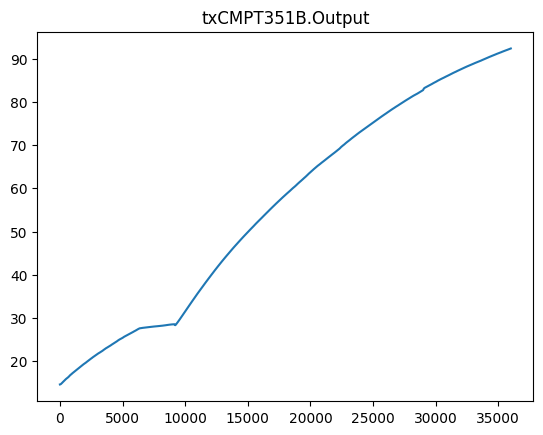

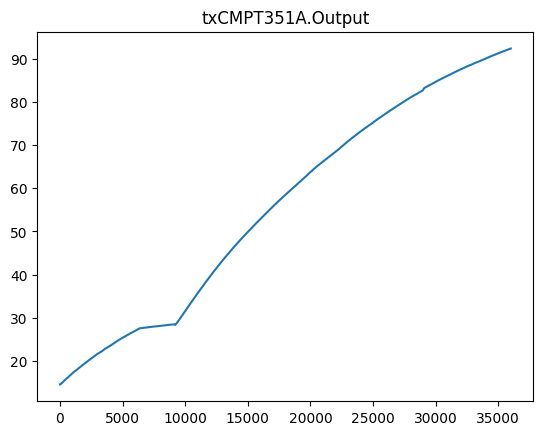

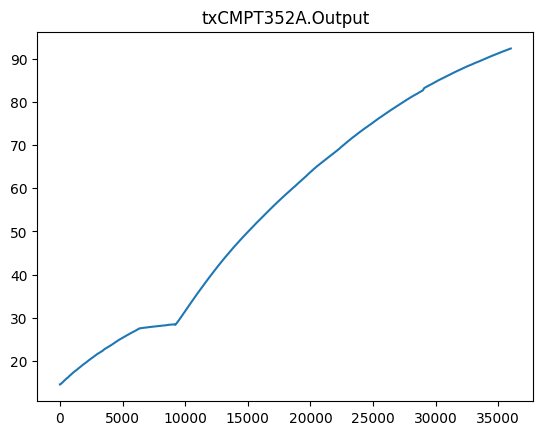

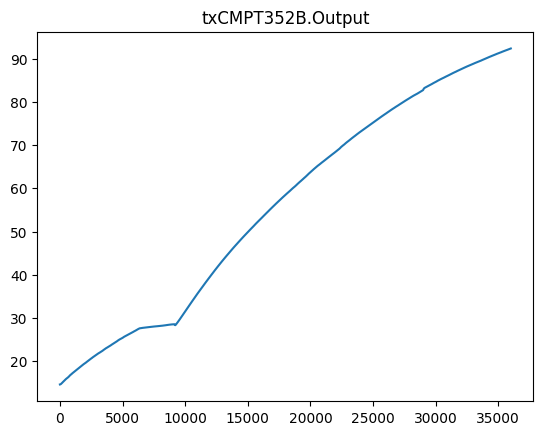

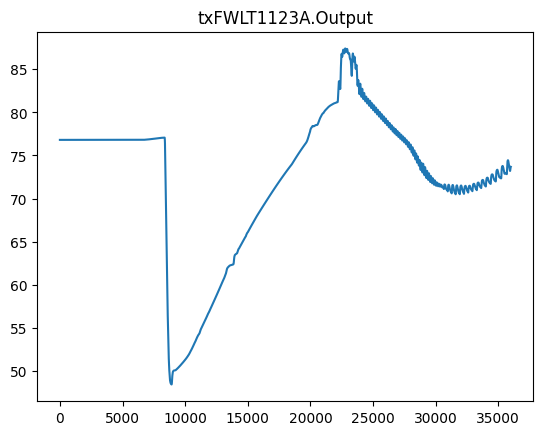

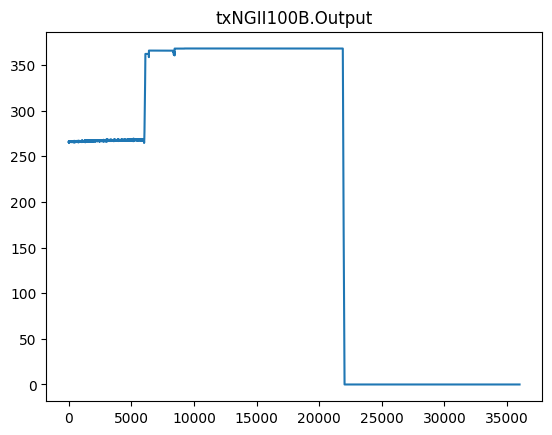

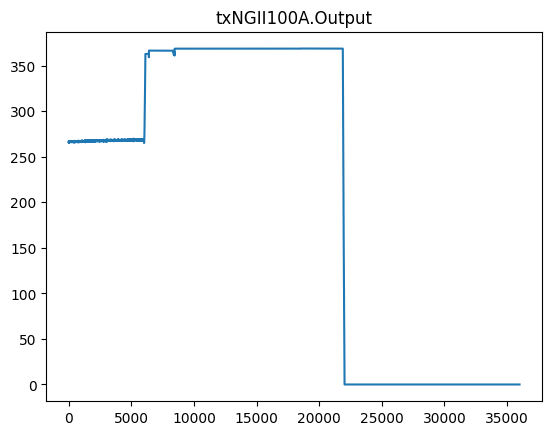

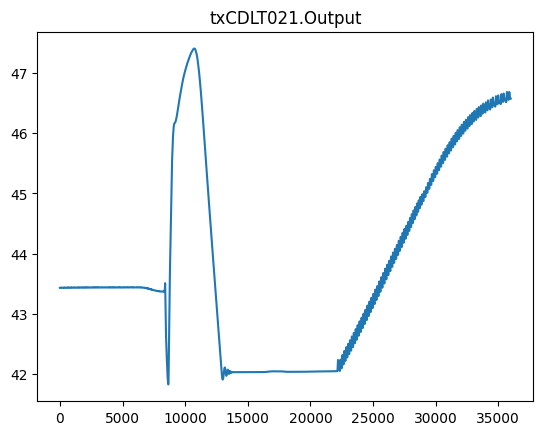

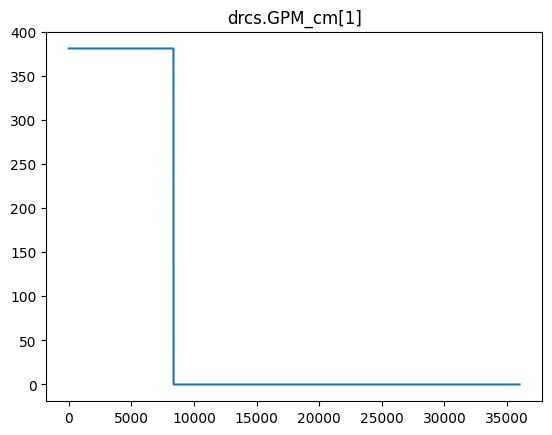

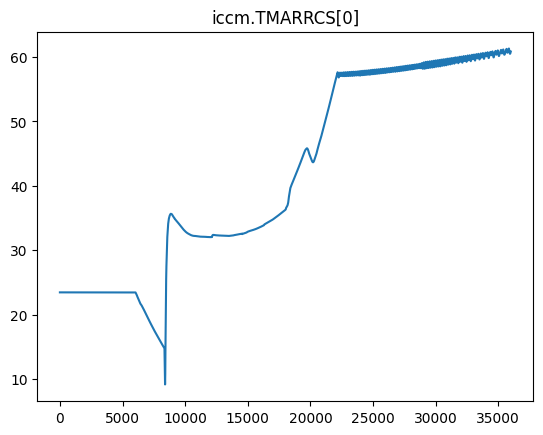

In [28]:
for node in sorted_sensors[:top_k]:
    plt.figure() # 새 그래프 창을 생성하여 그래프가 겹치지 않게 합니다.
    plt.plot(test_orig[node].values)
    plt.title(node) 
    
    plt.show()

In [29]:
def _keep_topk_edges_from_list(edge_list, top_k_edges=None):
    """
    edge_list: list of (u, v, w) with u!=v
    반환: 상위 |w| 큰 순으로 top_k_edges개만 남긴 리스트(또는 top_k_edges가 None이면 원본)
    """
    if top_k_edges is None or top_k_edges <= 0 or len(edge_list) <= top_k_edges:
        return edge_list
    edge_list = sorted(edge_list, key=lambda t: abs(t[2]), reverse=True)
    return edge_list[:top_k_edges]

def _induce_subgraph_by_topk_nodes(edge_list, top_k_nodes=None):
    """
    edge_list에서 가중 차수(노드별 ∑|w|) 상위 top_k_nodes만 남긴 유도 부분 그래프 반환
    """
    if top_k_nodes is None or top_k_nodes <= 0:
        return edge_list
    import collections
    deg = collections.defaultdict(float)
    for u, v, w in edge_list:
        a = float(abs(w))
        deg[u] += a; deg[v] += a
    keep_nodes = set([n for n, _ in sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:top_k_nodes]])
    return [(u, v, w) for (u, v, w) in edge_list if u in keep_nodes and v in keep_nodes]

def _draw_graph_from_edges(basePath, nodes_labels, edge_list, title, fname,
                           include_isolated=False):
    """
    include_isolated=False이면, 엣지에 등장한 노드만 그림(고립 노드 숨김).
    """
    import os, matplotlib.pyplot as plt, networkx as nx
    os.makedirs(basePath, exist_ok=True)
    G = nx.Graph()

    if include_isolated:
        # 모든 노드 추가(고립 노드도 보임)
        for n in nodes_labels:
            G.add_node(n)
    else:
        # 엣지에 등장한 노드만 추가
        used = set()
        for u, v, _ in edge_list:
            used.add(u); used.add(v)
        for n in used:
            G.add_node(n)

    # 엣지 추가
    for u, v, w in edge_list:
        if u == v:
            continue
        G.add_edge(u, v, weight=float(w))

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=600)
    if G.number_of_edges() > 0:
        widths = [1 + 2*abs(G[u][v]['weight']) for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=widths)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title); plt.axis('off')
    out = os.path.join(basePath, fname)
    plt.savefig(out, bbox_inches='tight', dpi=150)
    plt.show(); plt.close()
    return out

def plot_network_graph_from_corr(
    basePath, df: pd.DataFrame, threshold: float = None, with_labels: bool = True,
    top_k_edges: int = None, top_k_nodes: int = None, filename: str = 'sgtr_topk_corr.png'
):
    """
    상관 네트워크를 그리고 저장.
    - threshold: |corr| >= threshold만 사용 (None이면 제한 없음)
    - top_k_edges: 가중치(|corr|) 상위 K개의 엣지만 시각화
    - top_k_nodes: 가중 차수 상위 K개 노드만 남긴 유도 그래프
    """
    os.makedirs(basePath, exist_ok=True)

    num_df = df.select_dtypes(include=[np.number])
    if num_df.empty:
        raise ValueError("DataFrame has no numeric columns to compute correlations.")

    corr = num_df.corr().fillna(0)
    cols = list(corr.columns)

    # 엣지 리스트 만들기 (상삼각만)
    edges = []
    for i, a in enumerate(cols):
        for j in range(i+1, len(cols)):
            b = cols[j]
            w = float(corr.iloc[i, j])
            if threshold is not None and abs(w) < threshold:
                continue
            if a != b:
                edges.append((a, b, w))

    # 선택 규칙 적용
    if top_k_nodes:  # 노드 기준 유도 그래프 우선
        edges = _induce_subgraph_by_topk_nodes(edges, top_k_nodes=top_k_nodes)
    if top_k_edges:
        edges = _keep_topk_edges_from_list(edges, top_k_edges=top_k_edges)

    title = f"Correlation Network (top-{top_k_edges or 'all'} edges"
    if threshold is not None: title += f", |corr|≥{threshold:.2f}"
    if top_k_nodes: title += f", top-{top_k_nodes} nodes"
    title += ")"

    return _draw_graph_from_edges(basePath, cols, edges, title, filename)

def plot_network_graph_from_adjacency(
    basePath, labels, adjacency: np.ndarray, with_labels: bool = True,
    top_k_edges: int = None, top_k_nodes: int = None, filename: str = 'sgtr_topk_adj.png'
):
    """
    인접행렬 기반 네트워크를 그리고 저장.
    - top_k_edges: |weight| 상위 K개 엣지만 시각화
    - top_k_nodes: 가중 차수 상위 K개 노드만 남김
    """
    os.makedirs(basePath, exist_ok=True)
    A = np.asarray(adjacency)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("adjacency must be a square 2D matrix")
    if len(labels) != A.shape[0]:
        raise ValueError("labels length must match adjacency size")

    n = A.shape[0]
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            w = float(A[i, j])
            if w != 0:
                edges.append((str(labels[i]), str(labels[j]), w))

    if top_k_nodes:
        edges = _induce_subgraph_by_topk_nodes(edges, top_k_nodes=top_k_nodes)
    if top_k_edges:
        edges = _keep_topk_edges_from_list(edges, top_k_edges=top_k_edges)

    title = f"Adjacency Network (top-{top_k_edges or 'all'} edges"
    if top_k_nodes: title += f", top-{top_k_nodes} nodes"
    title += ")"

    return _draw_graph_from_edges(basePath, [str(l) for l in labels], edges, title, filename)

In [30]:
# 상위 10개 엣지에 해당하는 노드만 시각화
corr_path = plot_network_graph_from_corr(
    basePath, test,
    top_k_edges=10,            # 엣지 10개
    top_k_nodes=None,          # (선택) 노드 기준 필터는 사용 안 함
    filename='sgtr_top10_corr.png'
)

NameError: name 'basePath' is not defined

In [ ]:
def plot_radar(labels, series_values, series_names=None, value_range=None):
    """
    Draw a radar chart.
    labels: list[str] - axes names (e.g., classes or features)
    series_values: list[list[float]] - a list of value lists, one per series
    series_names: optional list[str] - legend names matching series_values
    value_range: (min,max) to fix radial limits; if None, auto from data
    Policy: one chart per call; no explicit colors set.
    """
    labels = [str(l) for l in labels]
    K = len(labels)
    if K < 3:
        raise ValueError("Radar chart needs at least 3 labels")
    angles = np.linspace(0, 2*np.pi, K, endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    # Value range
    all_vals = np.array([v for series in series_values for v in series])
    vmin = float(all_vals.min()) if value_range is None else float(value_range[0])
    vmax = float(all_vals.max()) if value_range is None else float(value_range[1])
    if vmin == vmax:
        vmax = vmin + 1.0
    ax.set_rlim(vmin, vmax)
    # Plot each series
    for idx, vals in enumerate(series_values):
        vals = list(vals)
        if len(vals) != K:
            raise ValueError("Each series must match the number of labels")
        vals += vals[:1]
        ax.plot(angles, vals)
        ax.fill(angles, vals, alpha=0.1)
    if series_names:
        ax.legend(series_names, loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.set_title("Radar Chart")
    plt.show()

# --- Quick usage examples (comment out if not needed) ---
try:
    # Try to detect class-level metrics dicts commonly named
    # e.g., per-class F1/precision/recall or feature importances
    labels = None
    series = None
    names = None
    # Heuristics for common variables
    cand_metrics = []
    for name in ['per_class_f1', 'per_class_scores', 'class_report', 'feature_importances_', 'saliency_scores', 'importance_by_feature']:
        if name in globals():
            cand_metrics.append(name)
    if 'per_class_scores' in globals() and isinstance(per_class_scores, dict):
        # per_class_scores = {'precision': [...], 'recall': [...], 'f1': [...]} with matching class labels
        if 'class_labels' in globals():
            labels = list(map(str, class_labels))
        else:
            # Try to infer length from one metric
            any_metric = next(iter(per_class_scores.values()))
            labels = [f"C{i}" for i in range(len(any_metric))]
        names = list(per_class_scores.keys())
        series = [per_class_scores[k] for k in names]
    elif 'saliency_scores' in globals():
        # Assume saliency_scores is a 1D array-like aligned with feature names
        feat_names = None
        for cand in ['feature_names', 'features_cols', 'X_columns']:
            if cand in globals():
                feat_names = globals()[cand]
                break
        if feat_names is None:
            # Try to infer from X
            if 'X' in globals() and hasattr(X, 'columns'):
                feat_names = list(map(str, X.columns))
        if feat_names is not None:
            labels = list(map(str, feat_names))[:10]  # limit for readability
            vals = np.asarray(saliency_scores)[:len(labels)]
            series = [vals]
            names = ["saliency"]
    
    if labels is not None and series is not None:
        plot_radar(labels, series, series_names=names)
    else:
        print("[Radar] Define labels/series and call plot_radar(labels, series_values, series_names)")
except Exception as e:
    print("[Radar] Skipped auto-plot:", e)


In [ ]:
BASE_DIR = "/mnt/data/image/network/hai"; os.makedirs(BASE_DIR, exist_ok=True)
KEEP_TOP = 0.10          # 상위 10% 엣지만 표시
NODE_SIZE_MIN = 300      # 노드 최소/최대 크기
NODE_SIZE_MAX = 1200
LABEL_OFFSET = 0.08      # 라벨을 노드에서 얼마나 떨어뜨릴지
WRAP_WIDTH  = 12         # 라벨 자동 줄바꿈 너비
LAYOUT_K_FACTOR = 1.6    # spring_layout k = LAYOUT_K_FACTOR / sqrt(N)
LAYOUT_ITER = 400        # 레이아웃 반복 횟수
TOPK_RADAR = 10          # 레이더 차트에 표시할 센서 개수

# -------------------- Utils --------------------
def _wrap_name(name: str, width: int = 12):
    from textwrap import wrap
    s = str(name)
    return "\n".join(wrap(s, width=width)) if len(s) > width else s

def _label_positions(pos: dict, offset: float = 0.06):
    import math
    pos_lbl = {}
    for n, (x, y) in pos.items():
        ang = math.atan2(y, x)
        pos_lbl[n] = (x + offset*np.cos(ang), y + offset*np.sin(ang))
    return pos_lbl

def _to_1d_edge_weights(edge_w, E, edge_index=None, n_nodes=None):
    # edge_w를 안전하게 (E,)로 변환
    if torch.is_tensor(edge_w):
        edge_w = edge_w.detach().cpu().numpy()
    arr = np.asarray(edge_w)
    if arr.ndim == 2 and n_nodes is not None and arr.shape == (n_nodes, n_nodes):
        src = edge_index[0].cpu().numpy() if torch.is_tensor(edge_index) else np.asarray(edge_index[0])
        dst = edge_index[1].cpu().numpy() if torch.is_tensor(edge_index) else np.asarray(edge_index[1])
        return arr[src, dst].astype(float)
    if arr.ndim == 2 and arr.shape[0] == E:
        return np.nanmean(np.abs(arr), axis=1).astype(float)
    if arr.ndim == 1 and arr.shape[0] == E:
        return arr.astype(float)
    if arr.ndim == 0 or (arr.ndim == 1 and arr.shape[0] == 1):
        return np.full(E, float(arr.ravel()[0]), dtype=float)
    return np.full(E, float(np.nanmean(arr)), dtype=float)

def make_adjacency_from_weights(n_nodes, edge_index, edge_w):
    src = edge_index[0].detach().cpu().numpy() if torch.is_tensor(edge_index) else np.asarray(edge_index[0])
    dst = edge_index[1].detach().cpu().numpy() if torch.is_tensor(edge_index) else np.asarray(edge_index[1])
    E = len(src)
    w1d = _to_1d_edge_weights(edge_w, E, edge_index=edge_index, n_nodes=n_nodes)
    A = np.zeros((n_nodes, n_nodes), dtype=float)
    for s, d, w in zip(src, dst, w1d):
        if 0 <= s < n_nodes and 0 <= d < n_nodes and np.isfinite(w):
            A[s, d] = w; A[d, s] = w
    return A

def draw_network_graph(A, labels, path, title,
                       keep_top=0.20, node_importance=None,
                       label_offset=0.06, wrap_width=12,
                       layout_k_factor=1.2, layout_iter=200):
    # 그래프 구성
    G = nx.Graph(); n = len(labels)
    for i in range(n): G.add_node(i, name=str(labels[i]))
    pos_vals = A[A > 0]
    thr = np.quantile(pos_vals, 1-keep_top) if pos_vals.size > 10 else 0.0
    for i in range(n):
        for j in range(i+1, n):
            w = float(A[i, j])
            if w > thr and w > 0:
                G.add_edge(i, j, weight=w)

    # 레이아웃
    k = layout_k_factor / max(1, np.sqrt(max(1, G.number_of_nodes())))
    pos = nx.spring_layout(G, seed=42, k=k, iterations=layout_iter)

    # 노드 크기 스케일링
    if node_importance is not None:
        imp = np.asarray(node_importance, dtype=float)

        # NaN-safe min/max
        lo = np.nanmin(imp) if np.isfinite(np.nanmin(imp)) else 0.0
        hi = np.nanmax(imp) if np.isfinite(np.nanmax(imp)) else 1.0
        rng = hi - lo

        if not np.isfinite(rng) or rng <= 0:
            # 모두 같거나 전부 NaN이면 균일 크기
            imp_norm = np.zeros_like(imp, dtype=float)
        else:
            imp_norm = (imp - lo) / (rng + 1e-12)

        node_sizes = NODE_SIZE_MIN + (NODE_SIZE_MAX - NODE_SIZE_MIN) * imp_norm
        node_sizes = [node_sizes[i] for i in G.nodes()]
    else:
        node_sizes = 600

def plot_radar(labels, series_values, series_names=None, value_range=None, path=None, title="Radar Chart"):
    labels = [str(l) for l in labels]; K = len(labels)
    assert K >= 3, "Radar chart needs at least 3 labels"
    angles = np.linspace(0, 2*np.pi, K, endpoint=False).tolist(); angles += angles[:1]

    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi/2); ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)

    all_vals = np.array([v for s in series_values for v in s], dtype=float)
    vmin = float(all_vals.min()); vmax = float(all_vals.max())
    if vmin == vmax: vmax = vmin + 1.0
    ax.set_rlim(vmin, vmax)

    line_handles = []
    for vals in series_values:
        vals = list(vals); vals += vals[:1]
        h, = ax.plot(angles, vals)          # 선 핸들 확보
        ax.fill(angles, vals, alpha=0.1)    # 면 채움(범례에는 안 씀)
        line_handles.append(h)

    if series_names is not None:
        ax.legend(handles=line_handles, labels=series_names, loc='upper right', bbox_to_anchor=(1.2, 1.1))

    ax.set_title(title)
    if path: plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.show(); plt.close()

# -------------------- Labels / N --------------------
try:
    feat_cols = [c for c in train.columns if c != "attack"]
except Exception:
    feat_cols = [f"f{i}" for i in range(144)]
N = len(feat_cols)

# -------------------- Static Graph --------------------
A_static = make_adjacency_from_weights(N, fixed_edge_index, base_pearson_weights)
static_deg = A_static.sum(axis=1)  # 정적 중심성(가중 차수)
draw_network_graph(
    A_static, feat_cols, os.path.join(BASE_DIR, "graph_static.png"),
    title="Static Graph (Pearson-based)",
    keep_top=KEEP_TOP, node_importance=static_deg,
    label_offset=LABEL_OFFSET, wrap_width=WRAP_WIDTH,
    layout_k_factor=LAYOUT_K_FACTOR, layout_iter=LAYOUT_ITER
)

# -------------------- Dynamic Graph (윈도우 마지막 시점 차분 재계산) --------------------
idx = 0
x_window, label, edge_index_use, final_edge_attr = test_dataset[idx]   # x_window: (W, N)
last = x_window[-1].numpy()                                            # (N,)
src = edge_index_use[0].numpy(); dst = edge_index_use[1].numpy()
edge_attr_dyn = np.abs(last[src] - last[dst])                          # (E,)
A_dynamic = make_adjacency_from_weights(N, edge_index_use, edge_attr_dyn)
dynamic_deg = A_dynamic.sum(axis=1)                                    # 동적 중심성
draw_network_graph(
    A_dynamic, feat_cols, os.path.join(BASE_DIR, "graph_dynamic.png"),
    title="Dynamic Graph (Last-step diff)",
    keep_top=KEEP_TOP, node_importance=dynamic_deg,
    label_offset=LABEL_OFFSET, wrap_width=WRAP_WIDTH,
    layout_k_factor=LAYOUT_K_FACTOR, layout_iter=LAYOUT_ITER
)

# -------------------- (가능 시) Attention Graph --------------------
# 모델/레이어가 alpha 반환을 지원하는 경우에만 try: 블록이 성공한다.
try:
    # 예시: trainer나 model에서 배치 idx에 대한 alpha를 얻는 헬퍼가 있다고 가정
    # out, (ei, alpha) = model.gat_layer(h_nodes, edge_index_use, final_edge_attr[idx], return_attention_weights=True)
    # 여기서는 final_edge_attr를 평균축약해서 GAT에 넣는다고 가정
    if 'model' in globals():
        with torch.no_grad():
            # 필요 시, 실제 forward와 동일한 전처리로 h_nodes를 만든다(여기선 생략/의사코드)
            # h_nodes_b: (N, F)
            # out, (ei, alpha) = model.gat1(h_nodes_b, edge_index_use, final_edge_attr.numpy(), return_attention_weights=True)
            pass
        # alpha_b = alpha.mean(dim=1).cpu().numpy()  # (E,)
        # A_attn = make_adjacency_from_weights(N, edge_index_use, alpha_b)
        # attn_deg = A_attn.sum(axis=1)
        # draw_network_graph(A_attn, feat_cols, os.path.join(BASE_DIR, "graph_attention.png"),
        #                    title="Attention Graph (avg heads)",
        #                    keep_top=KEEP_TOP, node_importance=attn_deg,
        #                    label_offset=LABEL_OFFSET, wrap_width=WRAP_WIDTH,
        #                    layout_k_factor=LAYOUT_K_FACTOR, layout_iter=LAYOUT_ITER)
except Exception as e:
    print("[Attention Graph] skipped:", e)

# -------------------- Radar: Static vs Dynamic 중심성 Top-K --------------------
combined = static_deg + dynamic_deg
top_idx = np.argsort(-combined)[:TOPK_RADAR]
radar_labels = [feat_cols[i] for i in top_idx]
series_vals = [static_deg[top_idx], dynamic_deg[top_idx]]
plot_radar(
    radar_labels, series_vals, series_names=["Static-degree","Dynamic-degree"],
    value_range=(0, max(series_vals[0].max(), series_vals[1].max())*1.05),
    path=os.path.join(BASE_DIR, "radar_topk_static_vs_dynamic.png"),
    title="Rader Chart {data} NPP-GTAD"
)

print("Saved under:", BASE_DIR)

In [ ]:
# ===== 1) 선택 변수 리스트 (스샷 그대로, Unnamed 제외) =====
# selected_vars_sgrtr = [
#     "CD_CondTemp",
#     "CD_InSteamFlow",
#     "AF_MakeupFlow",
#     "AF_LetdownFlow",
#     "RX_ReactorPower",
#     "SG1_LevelCtrlValvePos",
#     "SG2_LevelCtrlValvePos",
#     "PZ_Level",
#     "CTR_SG1LevelSetPoint",
# ]

selected_vars_hai = [
    "P1_LCV01D",
    "P2_SIT01",
    "P2_VT01e",
    "P1_FT01",
    "P1_LCV01Z",
    "P1_PIT01",
    "P2_VXT02",
]

# ===== 2) 유틸: 라벨 인덱스 매핑/서브그래프 만들기 =====
def _indices_for_names(all_labels, want_names):
    name_set = set(want_names)
    idx = [i for i, n in enumerate(all_labels) if n in name_set]
    found = [all_labels[i] for i in idx]
    missing = [n for n in want_names if n not in set(found)]
    if missing:
        print(f"[WARN] not found: {missing}")
    return idx, found

def _subgraph_by_nodes(A, labels, keep_idx):
    A_sub = A[np.ix_(keep_idx, keep_idx)]
    labels_sub = [labels[i] for i in keep_idx]
    return A_sub, labels_sub

# ===== 3) 실행: 선택 변수만 그리기 =====
# feat_cols, A_static, static_deg, A_dynamic, dynamic_deg 가 이미 만들어져 있다고 가정
# (만약 아직이라면, 너의 이전 셀에서 만든 run_static_graph / run_dynamic_graph 먼저 돌리면 됨)

# (1) 인덱스 뽑기
sel_idx, sel_labels = _indices_for_names(feat_cols, selected_vars_hai)

# (2) 정적 그래프 서브그래프 & 시각화
A_static_sel, labels_static_sel = _subgraph_by_nodes(A_static, feat_cols, sel_idx)
static_deg_sel = A_static_sel.sum(axis=1)
draw_network_graph(
    A_static_sel, labels_static_sel,
    os.path.join(BASE_DIR, "graph_static_SELECTED.png"),
    title="Static Graph (Selected variables)",
    keep_top=KEEP_TOP, node_importance=static_deg_sel,
    label_offset=LABEL_OFFSET, wrap_width=WRAP_WIDTH,
    layout_k_factor=LAYOUT_K_FACTOR, layout_iter=LAYOUT_ITER
)

# (3) 동적 그래프 서브그래프 & 시각화
A_dynamic_sel, labels_dynamic_sel = _subgraph_by_nodes(A_dynamic, feat_cols, sel_idx)
dynamic_deg_sel = A_dynamic_sel.sum(axis=1)
draw_network_graph(
    A_dynamic_sel, labels_dynamic_sel,
    os.path.join(BASE_DIR, "graph_dynamic_SELECTED.png"),
    title="Dynamic Graph (Selected variables)",
    keep_top=KEEP_TOP, node_importance=dynamic_deg_sel,
    label_offset=LABEL_OFFSET, wrap_width=WRAP_WIDTH,
    layout_k_factor=LAYOUT_K_FACTOR, layout_iter=LAYOUT_ITER
)

# (4) 레이더 차트 (선택 변수만)
plot_radar(
    labels_static_sel,
    [static_deg_sel, dynamic_deg_sel],
    series_names=["Static-degree","Dynamic-degree"],
    value_range=(0, float(max(static_deg_sel.max(), dynamic_deg_sel.max())*1.05)),
    path=os.path.join(BASE_DIR, "radar_SELECTED_static_vs_dynamic.png"),
    title="Rader Chart HAI (Ours)"
)

print("Saved:", BASE_DIR)

In [ ]:
# ==== ONE-CELL: 자동 탐색(ours/sota) + 신뢰도 시각화 세트 ====
import os, types, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

# -------------------- 사용자 데이터 바인딩 --------------------
SAVE_DIR = "/mnt/data/image/calibration"; os.makedirs(SAVE_DIR, exist_ok=True)

# y_true
if "test_labels" not in globals():
    raise NameError("test_labels 변수가 필요합니다. (정답 0/1 벡터)")
y_true = np.asarray(globals()["test_labels"]).astype(int)
N = len(y_true)

# -------------------- 헬퍼: 점수→확률 변환 --------------------
def _to_probs(arr):
    a = arr
    try:
        import torch
        if isinstance(a, torch.Tensor):
            a = a.detach().cpu().numpy()
    except Exception:
        pass
    a = np.asarray(a)
    if a.ndim == 2 and a.shape[0] == N:
        # (N,2): 확률 또는 로짓 → 양성 확률
        if np.all((a >= 0) & (a <= 1)) and np.allclose(a.sum(axis=1), 1, atol=1e-3):
            return a[:, 1]
        e = np.exp(a - a.max(axis=1, keepdims=True))
        sm = e / e.sum(axis=1, keepdims=True)
        return sm[:, 1]
    if a.ndim == 1 and a.shape[0] == N:
        # (N,): 확률 또는 로짓
        if a.min() >= 0 and a.max() <= 1:
            return a
        return 1.0 / (1.0 + np.exp(-a))
    raise ValueError(f"Unsupported shape for probs: {a.shape}")

def _len(x):
    try: return len(x)
    except Exception: return None

def _name_score(name: str):
    n = name.lower()
    score = 0
    # 우선순위 키워드 (ours vs sota/baseline)
    ours_kw = ["ours","our","new","current","gat","graph","edge","model"]
    sota_kw = ["sota","baseline","old","prev","teacher","xgb","lgbm","rf","svm","mlp","cat","logreg"]
    for kw in ours_kw + sota_kw + ["prob","probs","score","scores","logits","pred","output","yhat"]:
        if kw in n: score += 1
    # 보너스: ours/sota 쪽에 가중
    if any(kw in n for kw in ours_kw): score += 3
    if any(kw in n for kw in sota_kw): score += 3
    return score

def _gather_candidates(globs):
    cands = []
    for k, v in globs.items():
        if k.startswith("_"): continue
        if isinstance(v, (types.FunctionType, types.ModuleType)): continue
        # 배열/텐서만
        is_arr = isinstance(v, (list, tuple, np.ndarray))
        if not is_arr:
            try:
                import torch
                if isinstance(v, torch.Tensor):
                    is_arr = True
            except Exception:
                pass
        if not is_arr: continue

        L = _len(v)
        # 허용 형태: (N,) or (N,2)
        ok = (L == N)
        if not ok:
            try:
                vv = np.array(v)
                ok = (vv.ndim == 2 and vv.shape[0] == N and vv.shape[1] == 2)
            except Exception:
                ok = False
        if not ok: continue

        # 확률 변환 시도
        try:
            p = _to_probs(v)
        except Exception:
            continue
        if p.shape[0] != N or np.any(~np.isfinite(p)): continue

        # 엔트로피로 이상치 필터(전부 0/1 가까우면 살짝 페널티)
        pp = np.clip(p, 1e-6, 1-1e-6)
        ent = -(pp*np.log(pp) + (1-pp)*np.log(1-pp)).mean()  # ~[0,0.69]
        score = _name_score(k) + ent
        cands.append((score, k, p))
    # 점수순 정렬(내림차순)
    cands.sort(key=lambda x: x[0], reverse=True)
    return cands

cands = _gather_candidates(globals())

def _pick_pair(cands):
    """
    규칙:
    1) 이름에 ours/new/current가 포함된 후보를 우선 our로
    2) 이름에 sota/baseline/old/prev가 포함된 후보를 우선 sota로
    3) 위가 없으면 상위 2개 서로 다른 후보를 our/sota로
    4) 완전히 동일한 벡터면 제외하고 다음 후보
    """
    def has_any(name, kws): 
        n = name.lower()
        return any(kw in n for kw in kws)

    ours_kw = ["ours","our","new","current","gat","graph","edge","model"]
    sota_kw = ["sota","baseline","old","prev","teacher","xgb","lgbm","rf","svm","mlp","cat","logreg"]

    p_ours = p_sota = None
    name_ours = name_sota = None

    # 1) ours 후보
    for _, k, p in cands:
        if has_any(k, ours_kw):
            p_ours, name_ours = p, k; break
    # 2) sota 후보
    for _, k, p in cands:
        if has_any(k, sota_kw):
            # our와 동일 벡터 회피
            if p_ours is not None and np.allclose(p, p_ours, atol=1e-12): 
                continue
            p_sota, name_sota = p, k; break

    # 3) 보정: 못 찾았으면 상위 2개 서로 다르게
    if p_ours is None and len(cands) >= 1:
        name_ours, p_ours = cands[0][1], cands[0][2]
    if (p_sota is None) and len(cands) >= 2:
        for _, k, p in cands[1:]:
            if not np.allclose(p, p_ours, atol=1e-12):
                name_sota, p_sota = k, p; break

    return (name_ours, p_ours), (name_sota, p_sota)

(ours_pick, sota_pick) = _pick_pair(cands)
name_ours, p_ours = ours_pick
name_sota, p_sota = sota_pick

# 최종 검증/메시지
if p_ours is None or p_sota is None:
    print("[후보 변수 Top 12]")
    for s,k,_ in cands[:12]:
        print(f"  {k:>24s}  score={s:.3f}  shape={np.array(globals()[k]).shape}")
    raise NameError("p_ours 또는 p_sota를 자동으로 정하지 못했습니다. 위 목록에서 원하는 변수를 골라 "
                    "수동으로 지정하세요: p_ours = _to_probs(<var>); p_sota = _to_probs(<var>)")

p_ours = np.clip(p_ours, 1e-6, 1-1e-6)
p_sota = np.clip(p_sota, 1e-6, 1-1e-6)
print(f"[OK] p_ours ← {name_ours}")
print(f"[OK] p_sota ← {name_sota}")

# t_idx 준비(없으면 0..N-1)
if "t_idx" not in globals():
    t_idx = np.arange(N)
else:
    t_idx = np.asarray(globals()["t_idx"])

# -------------------- 시각화/지표 함수 --------------------
def calibration_curve(y, p, n_bins=15):
    y = np.asarray(y).astype(int)
    p = np.clip(np.asarray(p, dtype=float), 1e-6, 1-1e-6)
    bins = np.linspace(0, 1, n_bins+1)
    ids = np.digitize(p, bins) - 1
    prob_true, prob_pred, counts = [], [], []
    for b in range(n_bins):
        m = ids == b
        if m.any():
            prob_true.append(y[m].mean())
            prob_pred.append(p[m].mean())
            counts.append(int(m.sum()))
        else:
            prob_true.append(np.nan)
            prob_pred.append((bins[b]+bins[b+1])/2)
            counts.append(0)
    return np.array(prob_true), np.array(prob_pred), np.array(counts), bins

def ece(y, p, n_bins=15):
    pt, pp, c, _ = calibration_curve(y, p, n_bins)
    m = ~np.isnan(pt)
    if not m.any(): return np.nan
    w = c[m] / c[m].sum()
    return float(np.sum(w * np.abs(pt[m] - pp[m])))

def mce(y, p, n_bins=15):
    pt, pp, c, _ = calibration_curve(y, p, n_bins)
    m = ~np.isnan(pt)
    return float(np.max(np.abs(pt[m] - pp[m]))) if m.any() else np.nan

def plot_reliability(y, p_list, labels, n_bins=15, title="Reliability Diagram", save_path=None):
    plt.figure(figsize=(7.5,6))
    for p, lab in zip(p_list, labels):
        pt, pp, cnt, bins = calibration_curve(y, p, n_bins)
        m = ~np.isnan(pt)
        width = 1.0/n_bins
        plt.bar(pp[m], pt[m], width=width*0.95, alpha=0.25, label=f"{lab} (bin acc)")
        plt.plot(pp[m], pt[m], marker="o", linewidth=1.4, label=f"{lab}")
    xs = np.linspace(0,1,200)
    plt.plot(xs, xs, "--", linewidth=1.0, color="gray", label="Perfect")
    plt.xlabel("Predicted probability"); plt.ylabel("Empirical accuracy")
    plt.title(title); plt.legend(); plt.ylim(0,1); plt.xlim(0,1); plt.grid(alpha=0.25)
    if save_path: plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show(); plt.close()

def risk_coverage(y, p, qs=np.linspace(0,1,21)):
    y = np.asarray(y).astype(int); p = np.asarray(p, dtype=float)
    conf = np.maximum(p, 1-p)
    order = np.argsort(-conf)
    y_sorted = y[order]; p_sorted = p[order]
    cov, risk = [], []
    for q in qs:
        k = max(1, int(len(p_sorted)*q))
        y_k = y_sorted[:k]; p_k = p_sorted[:k]
        err = (y_k != (p_k >= 0.5)).mean()
        cov.append(k/len(p_sorted)); risk.append(err)
    return np.array(cov), np.array(risk)

def plot_risk_coverage(y, plist, labels, title="Risk–Coverage", save_path=None):
    plt.figure(figsize=(7,5))
    for p, lab in zip(plist, labels):
        cov, risk = risk_coverage(y, p)
        plt.plot(cov, risk, marker="o", label=lab)
    plt.xlabel("Coverage"); plt.ylabel("Error rate (Risk)")
    plt.title(title); plt.grid(alpha=0.25); plt.legend(); plt.ylim(0,1); plt.xlim(0,1)
    if save_path: plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show(); plt.close()

def uncertainty_auroc(y, p):
    y = np.asarray(y).astype(int); p = np.asarray(p, dtype=float)
    conf = np.maximum(p, 1-p)
    uncert = 1 - conf
    errors = (y != (p >= 0.5)).astype(int)
    if errors.sum()==0 or errors.sum()==len(errors):
        return np.nan
    return float(roc_auc_score(errors, uncert))

def classwise_reliability_by_pred(y_true, prob, n_bins=10, class_names=None, save_path=None, title="Classwise Reliability (by predicted class)"):
    """
    y_true: (N,) 정답 라벨 (0..C-1)
    prob  : (N,C) 각 클래스 확률.  (이진이면 (N,2)로 만들어주세요)
    """
    y_true = np.asarray(y_true).astype(int)
    prob = np.asarray(prob, dtype=float)
    if prob.ndim == 1:  # (N,) 이진의 양성확률만 있는 경우
        prob = np.stack([1-prob, prob], axis=1)

    N, C = prob.shape
    if class_names is None:
        class_names = [f"class={c}" for c in range(C)]

    cols = min(4, C)
    rows = int(np.ceil(C/cols))
    plt.figure(figsize=(4.6*cols, 3.8*rows))

    y_pred = np.argmax(prob, axis=1)

    for c in range(C):
        ax = plt.subplot(rows, cols, c+1)
        m = (y_pred == c)             # ★ c로 "예측된" 샘플만
        if not m.any():
            ax.set_title(f"{class_names[c]} (no preds)")
            ax.axis("off"); continue

        p_c = prob[m, c]              # 그 샘플들의 c 확률
        y_c = (y_true[m] == c).astype(int)  # 그중 정답 비율

        # binning
        bins = np.linspace(0, 1, n_bins+1)
        ids = np.digitize(p_c, bins) - 1
        prob_true, prob_pred = [], []
        for b in range(n_bins):
            mb = ids == b
            if mb.any():
                prob_true.append(y_c[mb].mean())          # 경험 정확도
                prob_pred.append(p_c[mb].mean())          # 평균 예측확률
            else:
                prob_true.append(np.nan)
                prob_pred.append((bins[b]+bins[b+1])/2)

        pt = np.array(prob_true); pp = np.array(prob_pred)
        mm = ~np.isnan(pt)

        width = 1.0/n_bins
        ax.bar(pp[mm], pt[mm], width=width*0.95, alpha=0.25)
        ax.plot(pp[mm], pt[mm], marker="o", linewidth=1.2)
        xs = np.linspace(0,1,200); ax.plot(xs, xs, "--", c="gray", lw=1.0)

        ax.set_title(class_names[c])
        ax.set_xlim(0,1); ax.set_ylim(0,1); ax.grid(alpha=0.2)

    plt.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.96])
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show(); plt.close()

def temporal_calibration_heatmap(y, p, t_idx, title="Temporal Calibration Gap", save_path=None):
    t_vals = np.unique(t_idx)
    gaps = []
    for t in t_vals:
        m = (t_idx == t)
        if not m.any(): gaps.append(np.nan); continue
        acc = (y[m] == (p[m] >= 0.5)).mean()
        conf = np.maximum(p[m], 1-p[m]).mean()
        gaps.append(conf - acc)
    gaps = np.asarray(gaps, dtype=float)
    plt.figure(figsize=(max(8, len(t_vals)*0.25), 2.4))
    plt.imshow(gaps[np.newaxis, :], aspect="auto", cmap="coolwarm", vmin=-0.5, vmax=0.5)
    plt.yticks([0],[title]); plt.xticks(range(len(t_vals)), t_vals, rotation=90)
    cbar = plt.colorbar(); cbar.set_label("Overconfidence (+) / Underconfidence (−)")
    if save_path: plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show(); plt.close()

# -------------------- 실행: 그림 & 지표 --------------------
rel_path = os.path.join(SAVE_DIR, "reliability_ours_vs_sota.png")
plot_reliability(y_true, [p_ours, p_sota], ["Ours","SOTA"],
                 n_bins=15, title="Reliability Diagram (Ours vs SOTA)", save_path=rel_path)

print("== Calibration Metrics ==")
rows = [
    {"name":"Ours", "ECE":ece(y_true,p_ours,15), "MCE":mce(y_true,p_ours,15),
     "Brier":brier_score_loss(y_true,p_ours),
     "NLL":log_loss(y_true, np.vstack([1-p_ours,p_ours]).T, labels=[0,1])},
    {"name":"SOTA", "ECE":ece(y_true,p_sota,15), "MCE":mce(y_true,p_sota,15),
     "Brier":brier_score_loss(y_true,p_sota),
     "NLL":log_loss(y_true, np.vstack([1-p_sota,p_sota]).T, labels=[0,1])},
]
for r in rows: print(r)

rc_path = os.path.join(SAVE_DIR, "risk_coverage_ours_vs_sota.png")
plot_risk_coverage(y_true, [p_ours, p_sota], ["Ours","SOTA"],
                   title="Risk–Coverage (Ours vs SOTA)", save_path=rc_path)

print("== Uncertainty AUROC (higher is better) ==")
print({"Ours": uncertainty_auroc(y_true, p_ours),
       "SOTA": uncertainty_auroc(y_true, p_sota)})

cw_path = os.path.join(SAVE_DIR, "classwise_reliability_ours.png")
classwise_reliability_grid(y_true, p_ours, n_bins=10,
                           title="Classwise Reliability – Ours", save_path=cw_path)
cw_path2 = os.path.join(SAVE_DIR, "classwise_reliability_sota.png")
classwise_reliability_grid(y_true, p_sota, n_bins=10,
                           title="Classwise Reliability – SOTA", save_path=cw_path2)

temp_path = os.path.join(SAVE_DIR, "temporal_calibration_gap_ours.png")
temporal_calibration_heatmap(y_true, p_ours, t_idx, title="Temporal Calibration Gap – Ours", save_path=temp_path)
temp_path2 = os.path.join(SAVE_DIR, "temporal_calibration_gap_sota.png")
temporal_calibration_heatmap(y_true, p_sota, t_idx, title="Temporal Calibration Gap – SOTA", save_path=temp_path2)

print("Saved figs under:", SAVE_DIR)


In [ ]:
def risk_coverage(y, p, qs=np.linspace(0,1,21)):
    y = np.asarray(y).astype(int); p = np.asarray(p, dtype=float)
    conf = np.maximum(p, 1-p)
    order = np.argsort(-conf)
    y_sorted = y[order]; p_sorted = p[order]
    cov, risk = [], []
    for q in qs:
        k = max(1, int(len(p_sorted)*q))
        y_k = y_sorted[:k]; p_k = p_sorted[:k]
        err = (y_k != (p_k >= 0.5)).mean()
        cov.append(k/len(p_sorted)); risk.append(err)
    return np.array(cov), np.array(risk)

def _load_vec(path, name):
    if not os.path.exists(path):
        raise FileNotFoundError(f"파일 없음: {path} ({name})")
    arr = np.load(path)
    if arr.ndim > 1:
        arr = arr.ravel()
    if not np.all(np.isfinite(arr)):
        raise ValueError(f"{name}에 NaN/Inf 포함: {path}")
    return arr

def plot_risk_coverage_from_files(
    dirpath="./analysis/sgtr",
    y_our_file="y_our.npy",
    p_our_file="p_our.npy",
    y_sota_file="y_sota.npy",
    p_sota_file="p_sota.npy",
    title="Risk–Coverage HAI (Ours vs CGAD)",
    save_path=None
):
    # 1) 로드
    y_our  = _load_vec(os.path.join(dirpath, y_our_file),  "y_our")
    p_ours = _load_vec(os.path.join(dirpath, p_our_file),  "p_our")
    y_sota = _load_vec(os.path.join(dirpath, y_sota_file), "y_sota")
    p_sota = _load_vec(os.path.join(dirpath, p_sota_file), "p_sota")

    # 2) 기본 검증/정리
    # 확률 클리핑
    p_ours = np.clip(p_ours.astype(float), 1e-6, 1-1e-6)
    p_sota = np.clip(p_sota.astype(float), 1e-6, 1-1e-6)

    # 길이 일치 확인 (라벨↔확률)
    if len(y_our) != len(p_ours):
        raise ValueError(f"len(y_our)={len(y_our)} != len(p_our)={len(p_ours)}")
    if len(y_sota) != len(p_sota):
        raise ValueError(f"len(y_sota)={len(y_sota)} != len(p_sota)={len(p_sota)}")

    # 두 라벨 벡터가 다르면 경고 후 교집합 길이로 자르기(보통 동일해야 정상)
    if len(y_our) != len(y_sota) or not np.array_equal(y_our, y_sota):
        print("[WARN] y_our와 y_sota가 동일하지 않습니다. 공통 길이로 맞춰 비교합니다.")
        L = min(len(y_our), len(y_sota))
        y = y_our[:L]  # 기준: y_our 앞부분
        p_ours = p_ours[:L]
        p_sota = p_sota[:L]
    else:
        y = y_our  # 동일하면 이것을 기준 라벨로 사용

    # 3) 플롯
    plt.figure(figsize=(7,5))
    cov_o, risk_o = risk_coverage(y, p_ours)
    cov_s, risk_s = risk_coverage(y, p_sota)
    plt.plot(cov_o, risk_o, marker="o", label="Ours")
    plt.plot(cov_s, risk_s, marker="o", label="CGAD")
    plt.xlabel("Coverage"); plt.ylabel("Error rate (Risk)")
    plt.title(title); plt.grid(alpha=0.25); plt.legend(); plt.ylim(0,1); plt.xlim(0,1)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"[OK] saved: {save_path}")
    plt.show(); plt.close()

plot_risk_coverage_from_files(
    dirpath="./analysis/hai",
    y_our_file="y_gtad.npy", p_our_file="p_gtad.npy",
    y_sota_file="y_cgad.npy", p_sota_file="p_cgad.npy",
    save_path="./analysis/sgtr/risk_coverage_ours_vs_sota.png"
)